In [2]:
from XTSTree.XTSTreePageHinkley import XTSTreePageHinkley
from plot import plot
import random
import numpy as np
import pandas as pd

Example Series

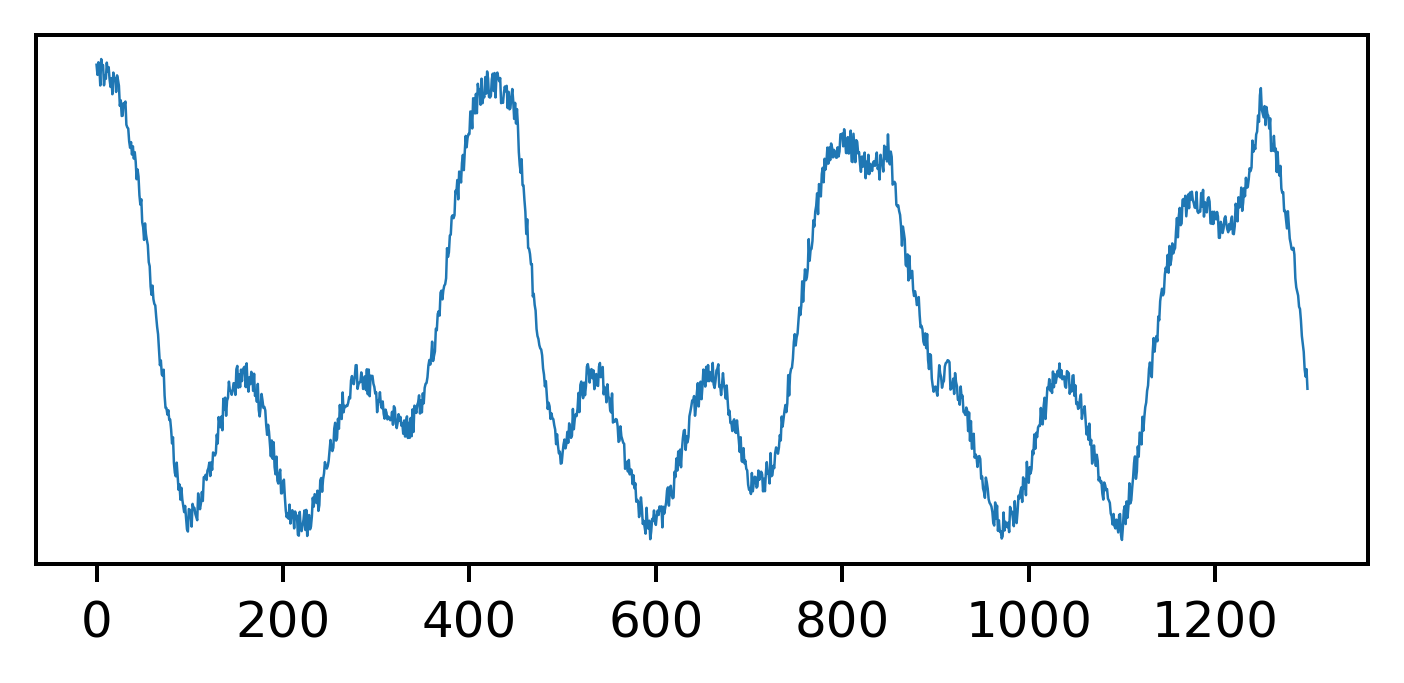

In [3]:
generator = np.random.default_rng(42)

series = np.concatenate([
  np.array(generator.uniform(-0.2, 0.2, 100)) + np.linspace(0, 5, 100)[::-1],
  
  np.array(generator.uniform(-0.2, 0.2, 200)),
  np.array(generator.uniform(-0.2, 0.2, 150)) + np.linspace(0, 5, 150),
  np.array(generator.uniform(-0.2, 0.2, 50)) + np.linspace(0, 5, 50)[::-1],

  np.array(generator.uniform(-0.2, 0.2, 200)),
  np.array(generator.uniform(-0.2, 0.2, 150)) + np.linspace(0, 5, 150),
  np.array(generator.uniform(-0.2, 0.2, 50)) + np.linspace(0, 5, 50)[::-1],

  np.array(generator.uniform(-0.2, 0.2, 200)),
  np.array(generator.uniform(-0.2, 0.2, 150)) + np.linspace(0, 5, 150),
  np.array(generator.uniform(-0.2, 0.2, 50)) + np.linspace(0, 5, 50)[::-1],
])
series = series + np.sin([i/20 for i in range(len(series))])

plot(series, show_axis=(True, False))

Creating XTSTree

In [4]:
xtstree = XTSTreePageHinkley(
  # Stopping condition, adf is the AdFuller test, and stop_val increases the threshold for a series to be non-stationary. The bigger stop_val gets, the harder it is for a cut to be made
  stop_condition='adf',
  stop_val=0,
  # Max iterations during the binary search before it decides between the cuts found
  max_iter=100,
  # Minimum distance between cuts so multiple cuts aren't created close to drastic changing points
  min_dist=int(len(series)/100),
  # Page-Hinkley parameters
	min_instances=30,
	delta=0.005,
	alpha=1 - 0.0001,
	# Starting value for Page-Hinkley threshold before binary search is used
	starting_threshold=50.0,
)

Creating cuts for the series

Não achei só um corte, escolhendo corte que gera maior pontuação, 881, 329.8689022092168, 2, 2


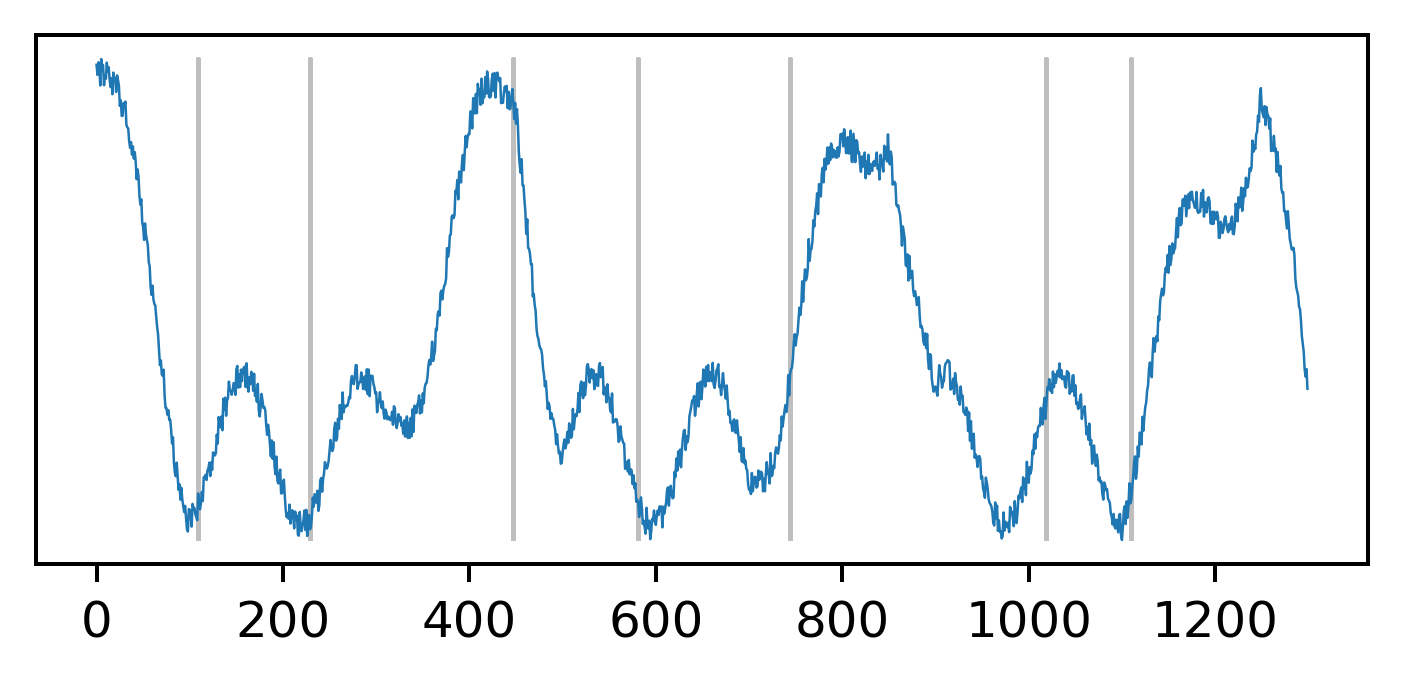

In [5]:
# Creates the splits based on the series
xtstree = xtstree.create_splits(series)

# Gets a list of the cut positions for the series
cuts = xtstree.cut_points()

plot(series, divisions=cuts, show_axis=(True, False))

Plotting cuts labelled by depth

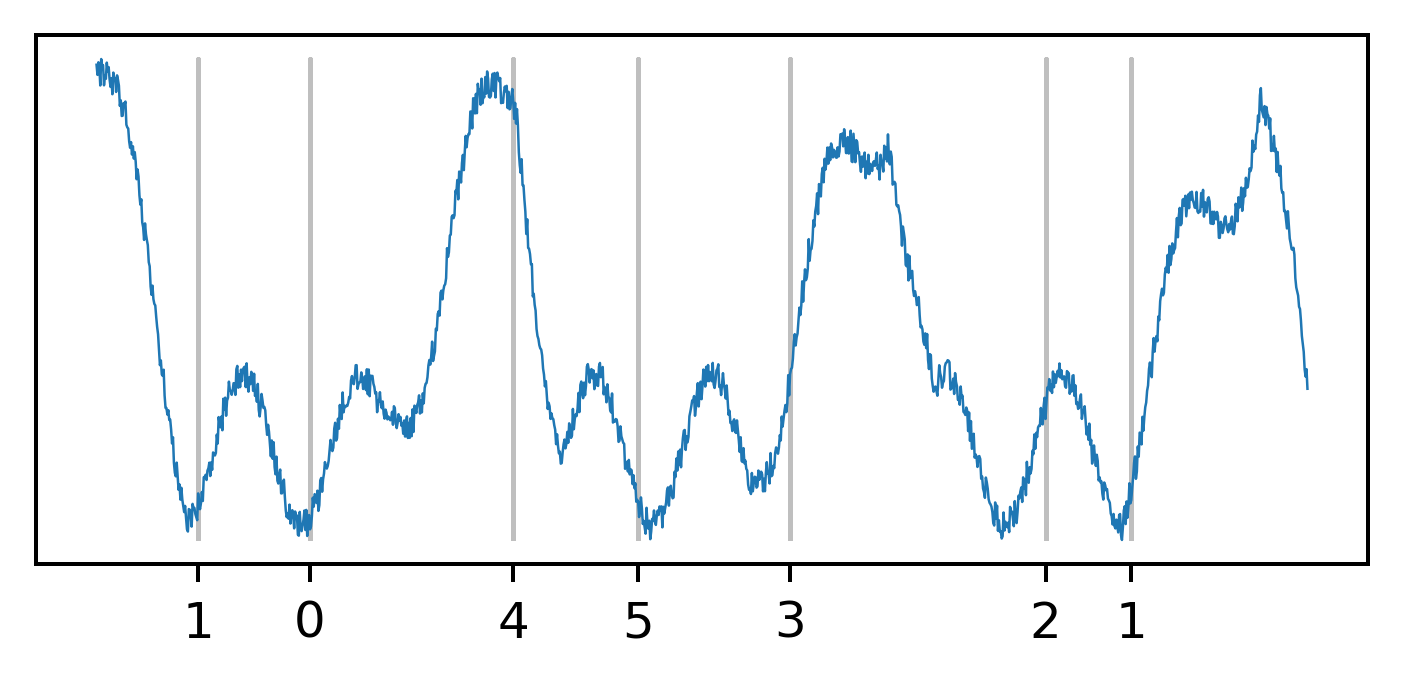

In [6]:
labels = []
for depth, d_cuts in xtstree.get_cuts_by_depth().items():
  for cut in d_cuts:
    labels.append({'x': cut, 'label': depth})

plot(series, divisions=cuts, show_axis=(True, False), labels=labels)

Iterating through series' cuts

In [7]:
for start, finish in zip([0, *cuts], [*cuts, len(series)]):
  print(len(series[start:finish]))
	# plot(series[start:finish], show_axis=(True, False))

109
120
218
134
163
274
92
190


Tree's heatmap

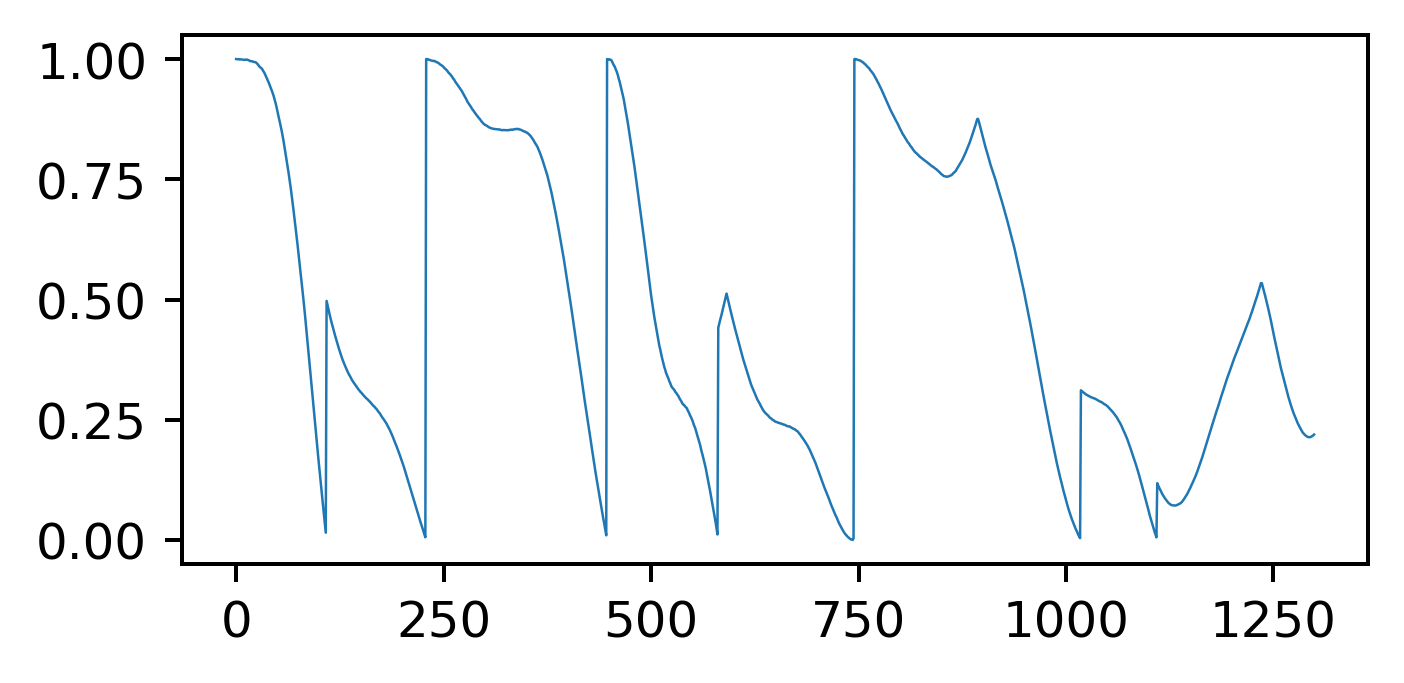

In [8]:
# The XTSTree stores a heatmap indicating how close the tree is to a cut
# When it hits 0, the cutting process starts

plot(xtstree.get_heatmap())

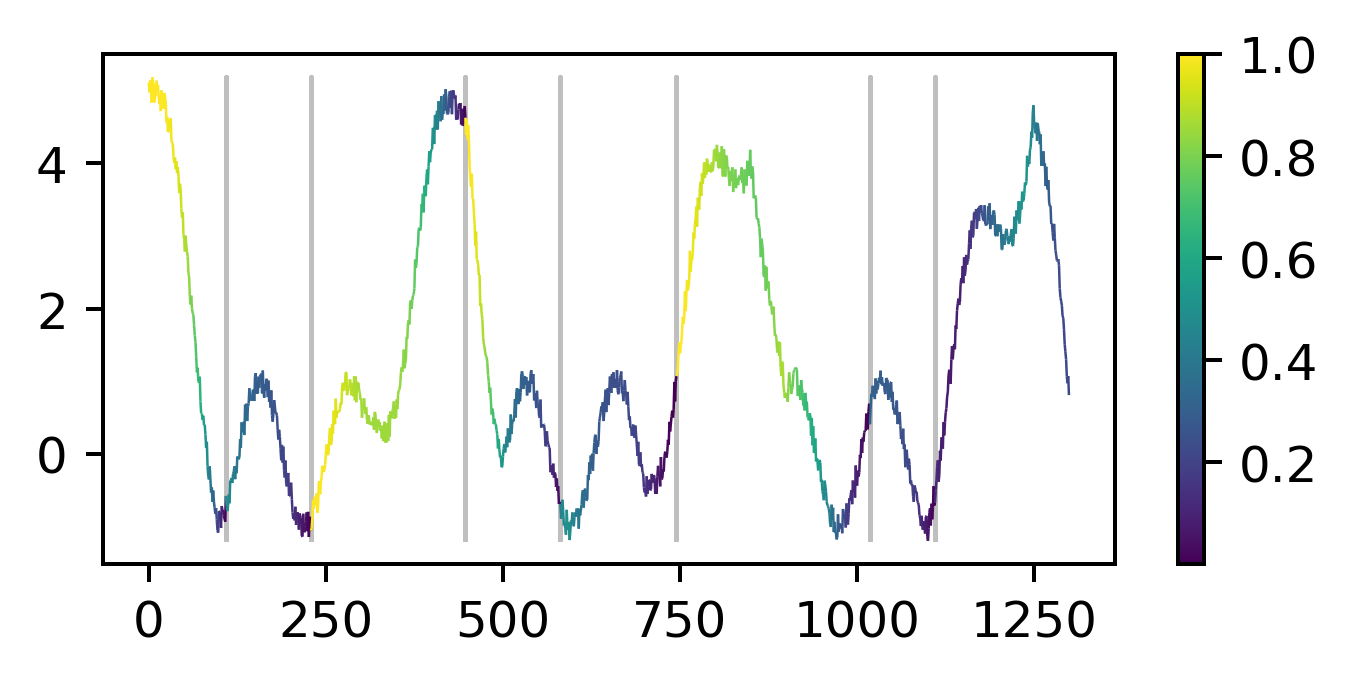

In [9]:
plot(series, color_gradient=xtstree.get_heatmap(), divisions=cuts)

Summary containing all cuts made by the XTSTree, divided by depth and with unique identifiers

In [11]:
xtstree.summary()

{0: [{'Root': 229}],
 1: [{'L': 109}, {'R': 1110}],
 2: [{'RL': 1018}],
 3: [{'RLL': 744}],
 4: [{'RLLL': 447}],
 5: [{'RLLLR': 581}]}

Returns segments from the series using only cuts from a specified depth

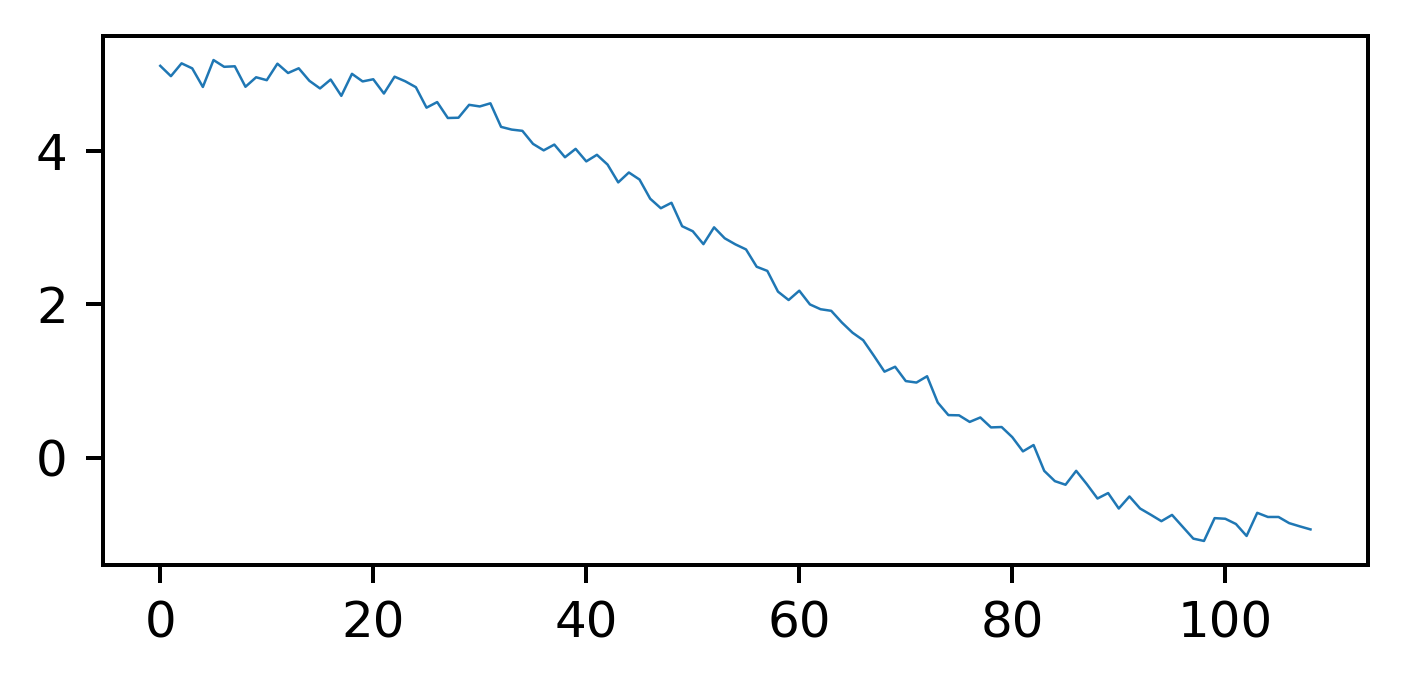

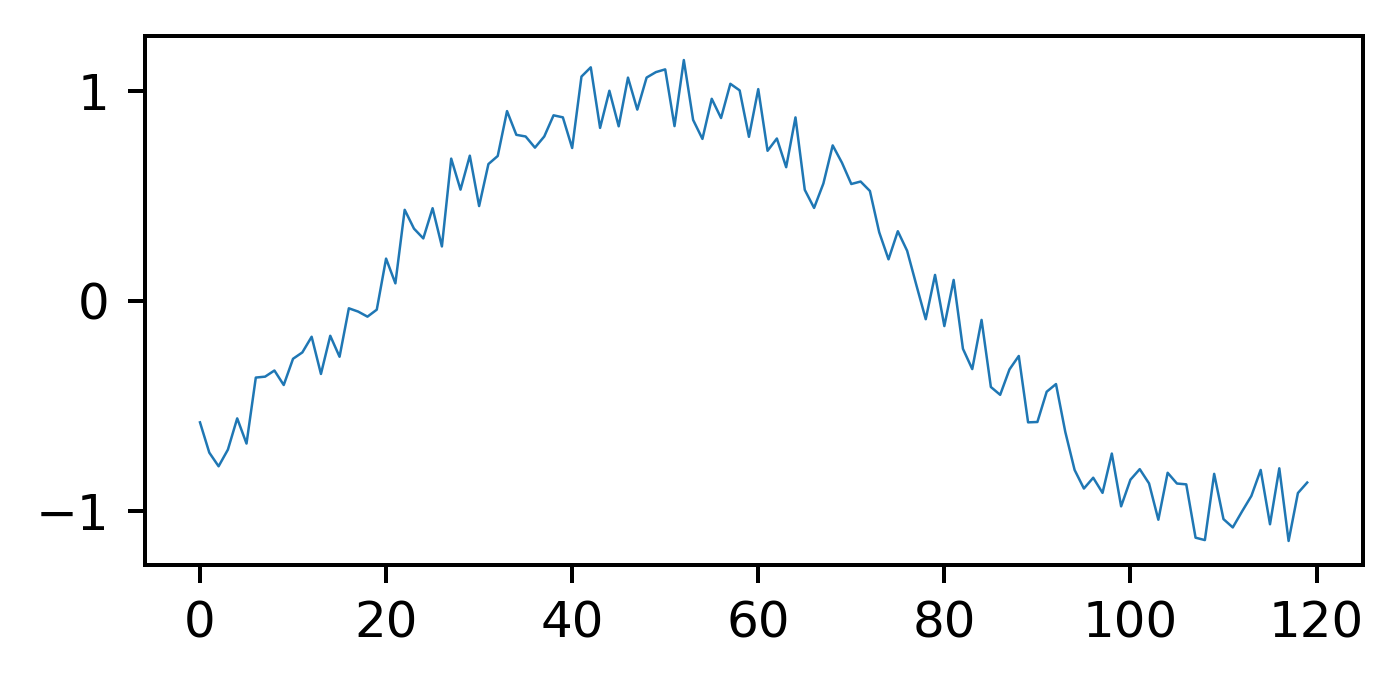

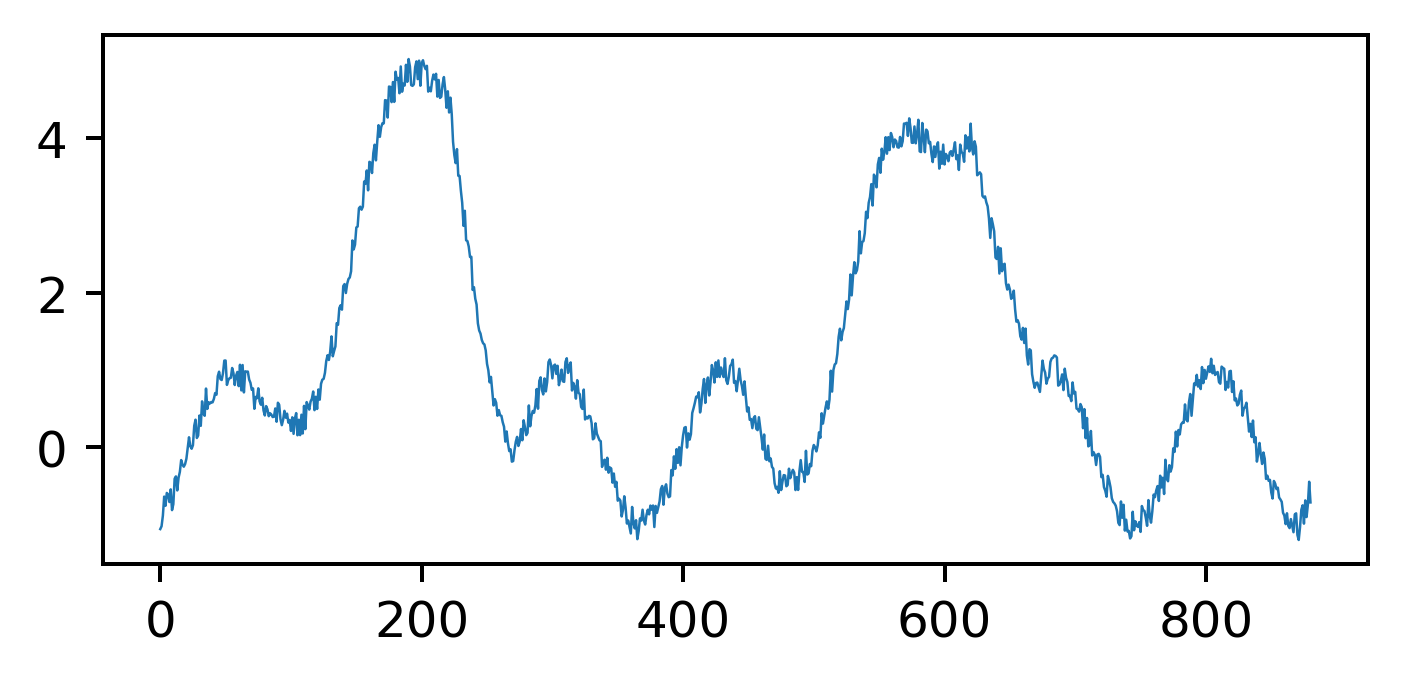

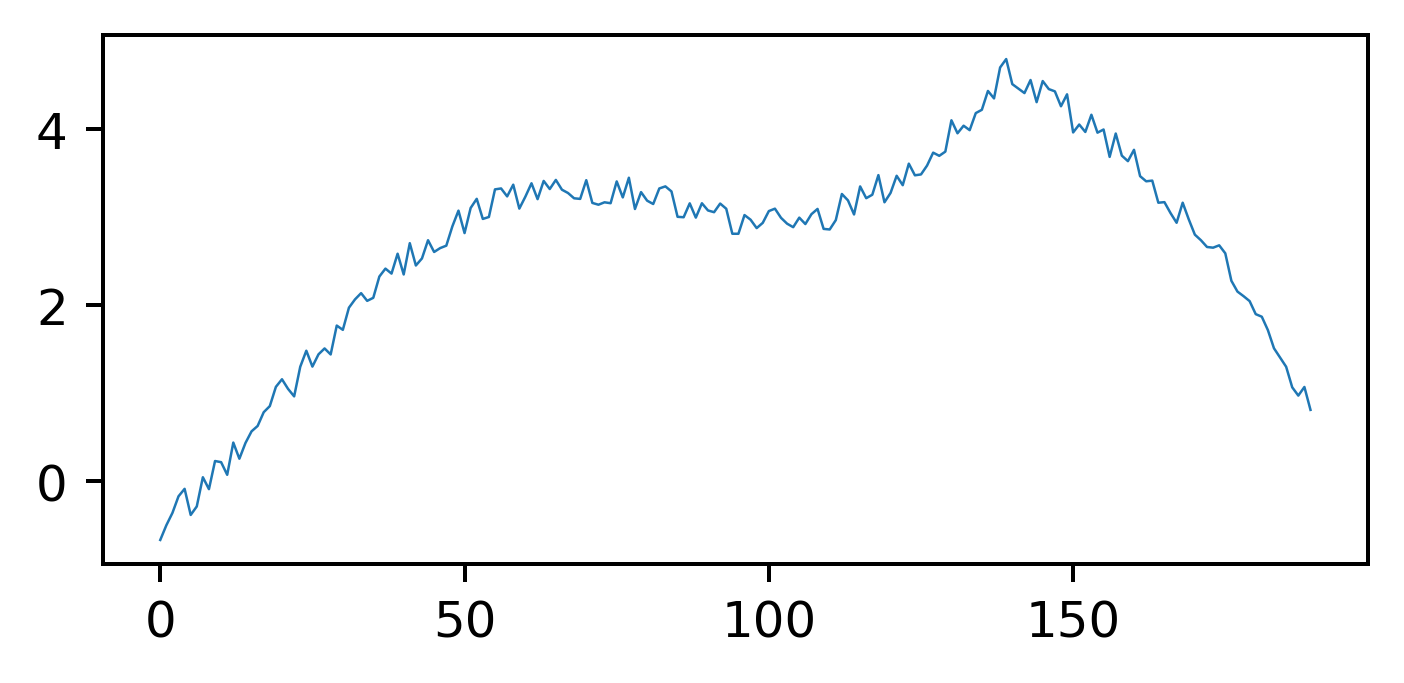

In [14]:
depth = 1
series_by_depth = xtstree.cut_series_by_depth(series)[depth]
for s in series_by_depth:
	plot(s)